100%|██████████| 9.91M/9.91M [00:00<00:00, 55.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.79MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.28MB/s]


Epoch [1/10], Loss: 0.0522
Epoch [2/10], Loss: 0.0439
Epoch [3/10], Loss: 0.0403
Epoch [4/10], Loss: 0.0384
Epoch [5/10], Loss: 0.0382
Epoch [6/10], Loss: 0.0379
Epoch [7/10], Loss: 0.0355
Epoch [8/10], Loss: 0.0364
Epoch [9/10], Loss: 0.0372
Epoch [10/10], Loss: 0.0342


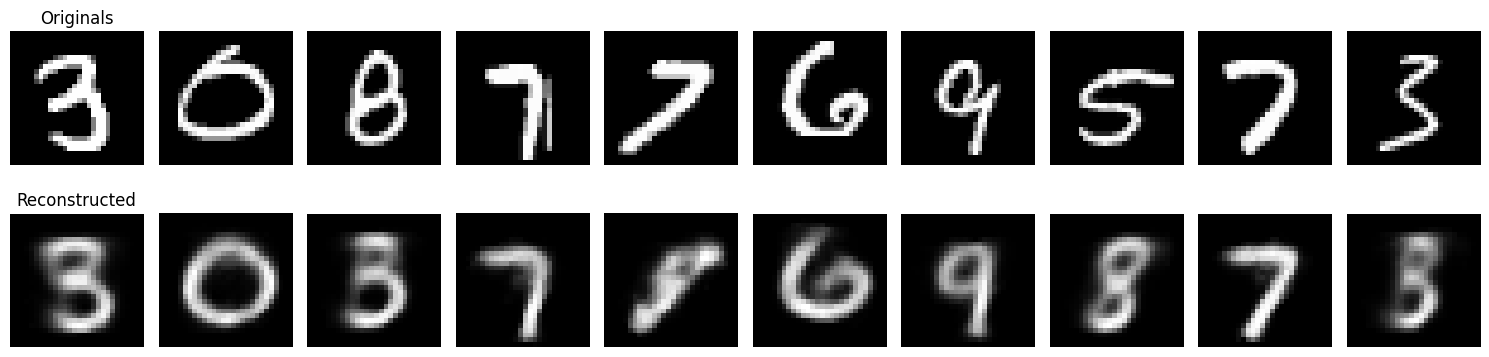

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

# MNIST dataset
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # For normalized pixel values (0-1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data  # we don't need labels
        img = img.view(img.size(0), -1).to(device)

        # Forward pass
        output = model(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualize original and reconstructed images
def show_reconstructed_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            output = model(img)
            break  # take only one batch

    # Reshape and convert to numpy for plotting
    img = img.view(-1, 1, 28, 28).cpu().numpy()
    output = output.view(-1, 1, 28, 28).cpu().numpy()

    # Plot
    f, axarr = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        axarr[0][i].imshow(img[i][0], cmap='gray')
        axarr[0][i].axis('off')
        axarr[1][i].imshow(output[i][0], cmap='gray')
        axarr[1][i].axis('off')

    axarr[0][0].set_title('Originals')
    axarr[1][0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

# Show results
show_reconstructed_images(model)
